In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, 
                             ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay)

## Знакомство с данными и их предобработка

In [2]:
# Чтение csv файла и формирование датафрейма.
path = os.path.join(os.getcwd(), 'train_5.csv')
data = pd.read_csv(path, sep=',')
data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [3]:
# Информация о наименовании колонок, типах данных, используемой памяти, кол-ве строк и колонок, кол-во непустых 
# значений в колонке.
data.info()
# 14 колонок, 8693 строки. 7 типов object, 6 типов numeric переменных. Есть пустые значения во всех колонках, кроме
# PassengerId, Transported (target column)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


True     4378
False    4315
Name: Transported, dtype: int64


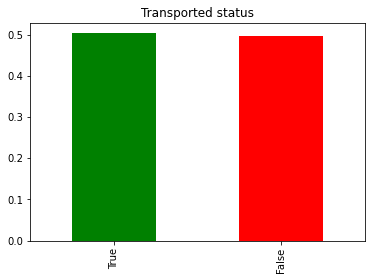

In [4]:
# Колонка Transported - Перенесся ли пассажир в другое измерение - target column.
# Количество и доля не перенесенных и перенесенных. Замечен баланс классов. 
print(data['Transported'].value_counts())
data['Transported'].value_counts(True).plot(kind='bar', title='Transported status', color = ['g', 'r'])
plt.show()

Описание колонок датасета  
PassengerId: уникальный идентификатор для каждого пассажира. Каждый идентификатор принимает форму gggg_pp, где gggg 
указывает группу, с которой путешествует пассажир, а pp — его номер в группе. Люди в группе часто являются членами семьи, 
но не всегда.  
HomePlanet: планета, с которой вылетел пассажир, как правило, планета их постоянного проживания.  
CryoSleep: указывает, решил ли пассажир быть переведенным в режим анабиоза на время рейса. Пассажиры, находящиеся в криосонном состоянии, находятся в своих каютах.  
Cabin: номер каюты, в которой находится пассажир. Принимает форму палуба/число/сторона, где сторона может быть либо P 
для левого борта, либо S для правого борта.  
Destination: планета, на которую будет высаживаться пассажир.  
Age: возраст пассажира.  
VIP: оплатил ли пассажир специальное VIP-обслуживание во время рейса.  
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: сумма, которую пассажир потратил в счет за каждое из многочисленных роскошных удобств космического корабля «Титаник».  
Name: имя и фамилия пассажира.  

In [5]:
# Уникальные значения для всех колонок датасета
for col in data.columns:
    print(data[col].value_counts())
    print('*'*30)

4392_01    1
3337_01    1
0365_01    1
3838_01    1
5208_01    1
          ..
5455_01    1
8964_01    1
3692_01    1
8783_01    1
6191_03    1
Name: PassengerId, Length: 8693, dtype: int64
******************************
Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64
******************************
False    5439
True     3037
Name: CryoSleep, dtype: int64
******************************
G/734/S     8
B/201/P     7
E/13/S      7
G/1368/P    7
B/82/S      7
           ..
F/1601/P    1
G/496/S     1
E/290/P     1
F/1637/S    1
F/1585/P    1
Name: Cabin, Length: 6560, dtype: int64
******************************
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64
******************************
24.0    324
18.0    320
21.0    311
19.0    293
23.0    292
       ... 
75.0      4
79.0      3
78.0      3
77.0      2
76.0      2
Name: Age, Length: 80, dtype: int64
******************************
False    8291
True      199
Nam

In [6]:
# Выведем кол-во пустых значений и % пустых значений в 12 колонках.
data_miss = data.isnull().sum()
percent_data_miss = round(data_miss/data.shape[0], 3)*100
missing_data = pd.concat([data_miss, percent_data_miss], axis=1, keys=['count_null', 'percent_null'])
missing_data[missing_data['count_null'] != 0].sort_values(by='count_null', ascending=False)

,count_null,percent_null
CryoSleep,217,2.5
ShoppingMall,208,2.4
VIP,203,2.3
HomePlanet,201,2.3
Name,200,2.3
Cabin,199,2.3
VRDeck,188,2.2
FoodCourt,183,2.1
Spa,183,2.1
Destination,182,2.1


In [7]:
# Доли уникальных значений для колонок RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - роскошь на корабле.
col_amenities = ['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in col_amenities:
    print(data[col].value_counts(True))
    print('*'*30)

0.0       0.655193
1.0       0.013745
2.0       0.009281
3.0       0.007166
4.0       0.005522
            ...   
1230.0    0.000117
987.0     0.000117
930.0     0.000117
3097.0    0.000117
1186.0    0.000117
Name: RoomService, Length: 1273, dtype: float64
******************************
0.0       0.641128
1.0       0.013631
2.0       0.008813
4.0       0.006228
3.0       0.006228
            ...   
3206.0    0.000118
3879.0    0.000118
734.0     0.000118
4076.0    0.000118
2325.0    0.000118
Name: FoodCourt, Length: 1507, dtype: float64
******************************
0.0       0.658456
1.0       0.018032
2.0       0.009428
3.0       0.006953
4.0       0.005303
            ...   
2454.0    0.000118
1770.0    0.000118
871.0     0.000118
9058.0    0.000118
1031.0    0.000118
Name: ShoppingMall, Length: 1115, dtype: float64
******************************
0.0       0.625617
1.0       0.017156
2.0       0.012338
5.0       0.006228
3.0       0.006228
            ...   
1104.0    0.000118
892.

Более 60% для каждой колонки (выше) приходится на значение 0. Заменим пропущенные значения в этих колонках на моду.  
Исходя из описания колонок HomePlanet, Destination, VIP, кол-ва и доли пропущенных значений и value_counts 
заполняем пропущенные значения модой. 

In [8]:
# Заполняем пропущенные значения модой для колонок в списках col_mode, col_amenities.
col_mode = ['HomePlanet', 'Destination', 'VIP']
for col in col_mode + col_amenities:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [9]:
# Колонки CryoSleep и 5 колонок расходов на услуги роскоши могут быть взаимосвязанными.
for col in col_amenities:
    print(data[data['CryoSleep'] == True][col].unique())
# Те, кто выбрал анабиоз во время перелета, скорее всего не имел расходов на услуги.

[0.]
[0.]
[0.]
[0.]
[0.]


In [10]:
# Колонки расходов для колонки CryoSleep с пропущенными значениями.
data[data['CryoSleep'].isna()][['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
92,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,570.0,2.0,131.0
104,0.0,331.0,0.0,0.0,1687.0
111,0.0,0.0,0.0,0.0,0.0
152,0.0,985.0,0.0,5.0,0.0
...,...,...,...,...,...
8620,0.0,0.0,0.0,0.0,0.0
8651,0.0,0.0,0.0,0.0,0.0
8664,0.0,0.0,0.0,0.0,0.0
8675,1030.0,1015.0,0.0,11.0,0.0


In [11]:
# Формируем новую колонку TotalSpend общих расходов на услуги по 5 удобствам корабля.
data['TotalSpend'] = data['RoomService'] + data['FoodCourt'] + data['ShoppingMall'] + data['Spa'] + data['VRDeck']

In [12]:
# Кол-во по колонке CryoSleep, которые не имели расходов за услуги.
data[data['TotalSpend'] == 0]['CryoSleep'].value_counts()

True     3037
False     518
Name: CryoSleep, dtype: int64

In [13]:
# Доля по колонке CryoSleep, которые не имели расходов за услуги.
data[data['TotalSpend'] == 0]['CryoSleep'].value_counts(True)

True     0.85429
False    0.14571
Name: CryoSleep, dtype: float64

In [14]:
# Заполним пропущенные значения по колонке CryoSleep. Если общая сумма расходов = 0, то анабиоз был, если != 0, то без анабиоза.
data.loc[(data['CryoSleep'].isna()) & (data['TotalSpend'] == 0), ['CryoSleep']] = True
data['CryoSleep'].fillna(False, inplace=True)

In [15]:
# Проверка заполнения пропущенных значений колонки CryoSleep
data['CryoSleep'].value_counts()

False    5558
True     3135
Name: CryoSleep, dtype: int64

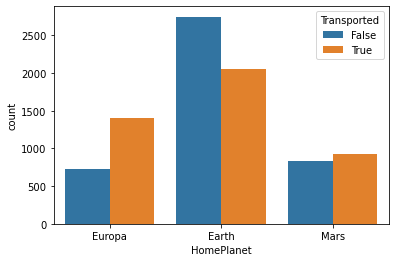

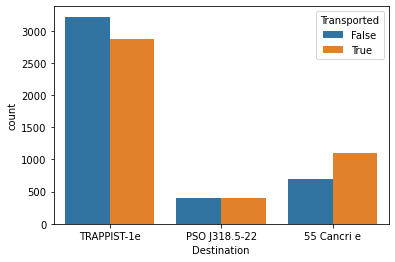

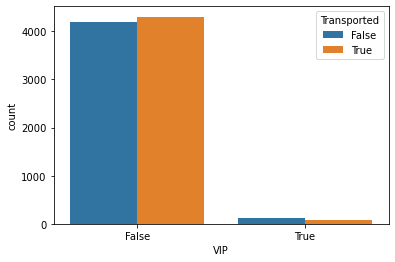

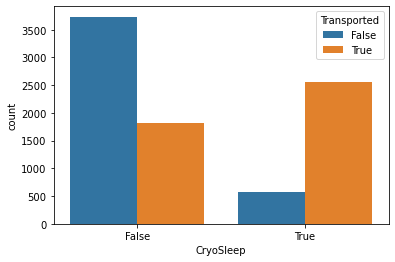

In [16]:
# Отображаем кол-ва по сгруппированным значениям в колонках HomePlanet, Destination, VIP, CryoSleep и статусу перенесения.
for col in col_mode + ['CryoSleep']:
    sns.countplot(data=data, x=col, hue='Transported')
    plt.show()

По графикам видно, что с HomePlanet Earth больше пассажиров не перенесены. В колонке CryoSleep больше пассажиров без анабиоза не перенесены. В колонке Destination больше пассажиров не перенесены на планету назначения TRAPPIST-1e. В колонке VIP большая часть пассажиров не воспользовалась VIP-обслуживанием и чуть больше пассажиров переместились без обслуживания, а те, кто выбрал VIP-обслуживание чуть больше пассажиров не переместилось.

In [17]:
# Исходя из описания Cabin делим колонку на колонки deck, side, опуская номер.
data['Deck'] = data['Cabin'].apply(lambda x:str(x)[:1])
data['Side'] = data['Cabin'].apply(lambda x:str(x)[-1:])

In [18]:
# Уникальные значение в колонке Deck, категорий палуб - 8, n - нет данных.
data['Deck'].value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
n     199
T       5
Name: Deck, dtype: int64

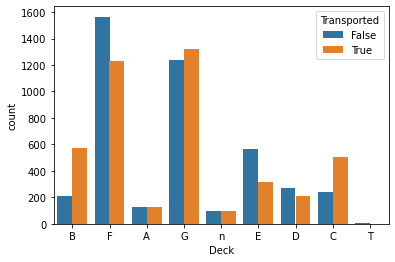

In [19]:
# Отобразим кол-во пассажиров по палубам и статусу перемещения. Больше пассажиров не переместилось по палубам F, E, D, T
# больше переместилось по палубам B, G, C.
sns.countplot(data=data, x='Deck', hue='Transported')
plt.show()

In [20]:
# Уникальные значение в колонке Side, категорий сторон - 2, n - нет данных. 
# Примерно одинаковое кол-во по левому и правому бортам.
data['Side'].value_counts()

S    4288
P    4206
n     199
Name: Side, dtype: int64

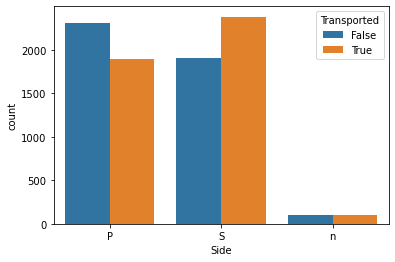

In [21]:
# Отобразим кол-во пассажиров по сторонам борта и статусу перемещения. Больше пассажиров не переместилось по левому борту Р,
# больше переместилось по правому борту S.
sns.countplot(data=data, x='Side', hue='Transported')
plt.show()

In [22]:
# Формируем две колонки Group и Num_group из колонки PassengerId
data[['Group', 'Num_group']] = data['PassengerId'].str.split('_', expand=True)

In [23]:
# Заменим пустые значения колонки Name на имя фамилия - Un Unknown.
data['Name'].fillna('Un Unknown', inplace=True)

In [24]:
# Формируем колонку с фамилией пассажира.
data['Last_name'] = data['Name'].str.split(expand=True)[1]

In [25]:
# Группируем по группам и выводим кол-во уникальных значений в группе по колонкам Cabin и Last_name.
# Принадлежность к группе из id не означает точно, что они находятся в одной каюте и принадлежат одной семье.
group_name = data.groupby(['Group'])[['Cabin', 'Last_name']].agg('nunique')
group_name[group_name['Cabin'] > 1]

,Cabin,Last_name
Group,,
0006,2,1
0017,2,1
0064,2,2
0067,2,1
0091,2,1
...,...,...
9208,2,2
9219,2,1
9220,2,2


In [26]:
# Пример. Группа из 7-и пассажиров, находящихся в разных каютах.
data[data['Group'] == '3862']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalSpend,Deck,Side,Group,Num_group,Last_name
3587,3862_01,Mars,True,F/729/S,55 Cancri e,38.0,False,0.0,0.0,0.0,0.0,0.0,Rohs Paie,True,0.0,F,S,3862,01,Paie
3588,3862_02,Mars,False,E/256/S,TRAPPIST-1e,21.0,False,2627.0,0.0,597.0,0.0,0.0,Blakes Ple,True,3224.0,E,S,3862,02,Ple
3589,3862_03,Mars,True,E/256/S,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,Un Unknown,False,0.0,E,S,3862,03,Unknown
3590,3862_04,Mars,False,D/124/S,TRAPPIST-1e,13.0,False,974.0,0.0,1883.0,0.0,505.0,Herms Cako,False,3362.0,D,S,3862,04,Cako
3591,3862_05,Mars,False,F/729/S,TRAPPIST-1e,54.0,False,149.0,981.0,215.0,0.0,0.0,Cherry Paie,True,1345.0,F,S,3862,05,Paie
3592,3862_06,Mars,False,F/729/S,TRAPPIST-1e,13.0,False,1008.0,667.0,8.0,0.0,0.0,Bants Cako,False,1683.0,F,S,3862,06,Cako
3593,3862_07,Mars,False,D/124/S,TRAPPIST-1e,18.0,False,12.0,0.0,1105.0,658.0,16.0,Chex Ple,False,1791.0,D,S,3862,07,Ple


In [27]:
# Есть пассажиры с одинаковыми именем и фамилией, их 20. 
names = data.groupby('Name').agg('count')
names[names['PassengerId'] > 1]['Last_name']

Name
Alraium Disivering      2
Ankalik Nateansive      2
Anton Woody             2
Apix Wala               2
Asch Stradick           2
Carry Contrevins        2
Cuses Pread             2
Dia Cartez              2
Elaney Webstephrey      2
Glena Hahnstonsen       2
Glenna Valezaley        2
Gollux Reedall          2
Grake Porki             2
Gwendy Sykess           2
Juane Popelazquez       2
Keitha Josey            2
Loree Wolfernan         2
Sharie Gallenry         2
Sus Coolez              2
Troya Schwardson        2
Un Unknown            200
Name: Last_name, dtype: int64

In [28]:
# Посмотрим на одних из пассажиров с одинаковыми именем и фамилией.
data[data['Name'] == 'Troya Schwardson']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalSpend,Deck,Side,Group,Num_group,Last_name
1737,1850_01,Earth,False,F/356/S,PSO J318.5-22,54.0,False,0.0,316.0,257.0,0.0,0.0,Troya Schwardson,False,573.0,F,S,1850,01,Schwardson
3381,3640_02,Earth,True,G/589/S,TRAPPIST-1e,41.0,False,0.0,0.0,0.0,0.0,0.0,Troya Schwardson,False,0.0,G,S,3640,02,Schwardson


In [29]:
# Кол-во уникальных id - 8693.
data['PassengerId'].nunique()

8693

In [30]:
# Кол-во уникальных групп - 6217.
data['Group'].nunique()

6217

In [31]:
# Кол-во уникальных номеров в группе - 8.
data['Num_group'].value_counts(True)

01    0.715173
02    0.162430
03    0.065685
04    0.026573
05    0.014724
06    0.008628
07    0.005292
08    0.001495
Name: Num_group, dtype: float64

In [32]:
# Заменяем колонку Num_group на колонку с кол-вом пассажиров, которые находятся в группе с данным пассажиром, помимо него.
data['Num_group'] = data.groupby('Group')['Num_group'].transform(lambda x: (x.count() - 1))
data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalSpend,Deck,Side,Group,Num_group,Last_name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,B,P,0001,0,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,F,S,0002,0,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,A,S,0003,1,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,A,S,0003,1,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,F,S,0004,0,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,8536.0,A,P,9276,0,Noxnuther
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,0.0,G,S,9278,0,Mondalley
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,1873.0,G,S,9279,0,Connon
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,4637.0,E,S,9280,1,Hontichre


In [33]:
# Уникальных значений по колонке Age - 80. Вывели описательную статистику для колонки Age. Мин - 0, макс - 79 лет, 
# медиана - 27 лет, среднее - примерно 29 лет.
print(data['Age'].value_counts())
data['Age'].describe()

24.0    324
18.0    320
21.0    311
19.0    293
23.0    292
       ... 
75.0      4
79.0      3
78.0      3
77.0      2
76.0      2
Name: Age, Length: 80, dtype: int64


count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

In [34]:
# Исходя из описания колонки Age, кол-ва и доли пропущенных значений и value_counts заполняем пропущенные значения медианой.
data['Age'].fillna(data['Age'].median(), inplace=True)

In [35]:
# Выводим описательную статистику после заполнения пропущенных значений
data['Age'].describe()

count    8693.000000
mean       28.790291
std        14.341404
min         0.000000
25%        20.000000
50%        27.000000
75%        37.000000
max        79.000000
Name: Age, dtype: float64

In [36]:
# Разделим пассажиров на 4 категории по возрасту.
data['Age_bin'] = pd.qcut(data['Age'], 4)

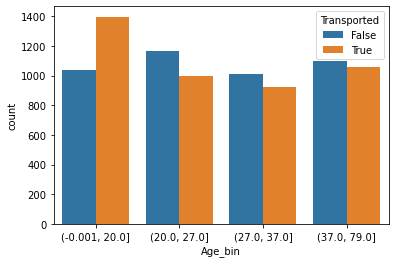

In [37]:
# Отобразим кол-во пассажиров по категориям возрастов и статусу перенесения.
# В категории до 20 лет больше пассажиров, которые были перенесены.
sns.countplot(data=data, x='Age_bin', hue='Transported')
plt.show()

In [38]:
# Формируем новые колонки долей расходов каждого удобства к общему расходу.
for col in col_amenities:
    data[f'{col}_p'] = round(data[col]/data['TotalSpend'], 2)

In [39]:
# Заменим значения NaN на 0, полученные при делении на 0, в колонках долей расходов каждого удобства к общему расходу.
col_amenities_p = ['RoomService_p', 'FoodCourt_p', 'ShoppingMall_p', 'Spa_p', 'VRDeck_p']
data[col_amenities_p] = data[col_amenities_p].fillna(0)

In [40]:
# Выведем описательную статистику для колонки TotalSpend. Мин и 1-й квартиль- 0, макс - около 36000, медиана - 716, 
# среднее и 3-й квартиль - примерно 1441.
data['TotalSpend'].describe()

count     8693.000000
mean      1440.866329
std       2803.045694
min          0.000000
25%          0.000000
50%        716.000000
75%       1441.000000
max      35987.000000
Name: TotalSpend, dtype: float64

In [41]:
# Кол-во уникальных значений колонки TotalSpend.
data['TotalSpend'].value_counts()

0.0        3653
809.0        54
788.0        40
804.0        39
803.0        34
           ... 
4234.0        1
4681.0        1
12439.0       1
10412.0       1
12386.0       1
Name: TotalSpend, Length: 2336, dtype: int64

In [42]:
# Разделим пассажиров на 7 категорий по уровню расходов на услуги роскоши.
data['TotalSpend_bin'] = pd.cut(data['TotalSpend'], [-0.1, 750, 1500, 3000, 6000, 12000, 24000, 48000])

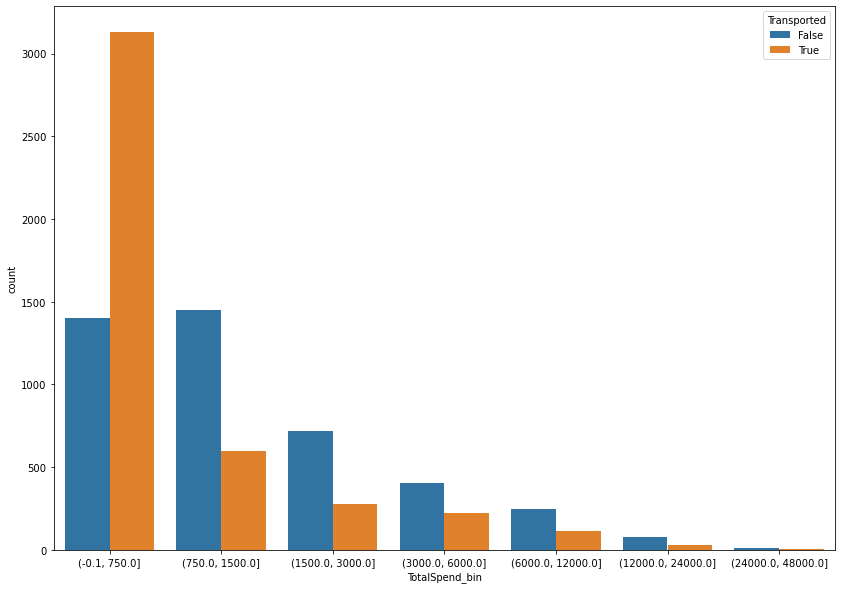

In [43]:
# Отобразим кол-во пассажиров по категориям расходов и статусу перенесения.
# Больше пассажиров было перенесено в первой категории до 750.
plt.figure(figsize=(14, 10))
sns.countplot(data=data, x='TotalSpend_bin', hue='Transported')
plt.show()

In [44]:
# Отобразим информацию о датасете для понимания того, какие колонки удалять и переставлять.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   PassengerId     8693 non-null   object  
 1   HomePlanet      8693 non-null   object  
 2   CryoSleep       8693 non-null   bool    
 3   Cabin           8494 non-null   object  
 4   Destination     8693 non-null   object  
 5   Age             8693 non-null   float64 
 6   VIP             8693 non-null   bool    
 7   RoomService     8693 non-null   float64 
 8   FoodCourt       8693 non-null   float64 
 9   ShoppingMall    8693 non-null   float64 
 10  Spa             8693 non-null   float64 
 11  VRDeck          8693 non-null   float64 
 12  Name            8693 non-null   object  
 13  Transported     8693 non-null   bool    
 14  TotalSpend      8693 non-null   float64 
 15  Deck            8693 non-null   object  
 16  Side            8693 non-null   object  
 17  Group         

In [45]:
# Удаляем колонки PassengerId, Cabin, Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, TotalSpend, Group - 
# выделили в другие колонки; Name, Last_name - нет значимой информации.
data.drop(['PassengerId', 'Cabin', 'Age', 'RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Last_name', \
           'TotalSpend', 'Group'], axis=1, inplace=True)

In [46]:
# Проверка заполнения пропущенных значений. Пропущенных значений в колонках нет.
print(data.isnull().sum().sum())
data.isna().sum().sum()

0


0

In [47]:
# Перестановка target column.
columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'Num_group', 'Age_bin', 'RoomService_p', 
           'FoodCourt_p', 'ShoppingMall_p', 'Spa_p', 'VRDeck_p', 'TotalSpend_bin', 'Transported']
data = data.reindex(columns=columns)
data

,HomePlanet,CryoSleep,Destination,VIP,Deck,Side,Num_group,Age_bin,RoomService_p,FoodCourt_p,ShoppingMall_p,Spa_p,VRDeck_p,TotalSpend_bin,Transported
0,Europa,False,TRAPPIST-1e,False,B,P,0,"(37.0, 79.0]",0.00,0.00,0.00,0.00,0.00,"(-0.1, 750.0]",False
1,Earth,False,TRAPPIST-1e,False,F,S,0,"(20.0, 27.0]",0.15,0.01,0.03,0.75,0.06,"(-0.1, 750.0]",True
2,Europa,False,TRAPPIST-1e,True,A,S,1,"(37.0, 79.0]",0.00,0.34,0.00,0.65,0.00,"(6000.0, 12000.0]",False
3,Europa,False,TRAPPIST-1e,False,A,S,1,"(27.0, 37.0]",0.00,0.25,0.07,0.64,0.04,"(3000.0, 6000.0]",False
4,Earth,False,TRAPPIST-1e,False,F,S,0,"(-0.001, 20.0]",0.28,0.06,0.14,0.52,0.00,"(750.0, 1500.0]",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,True,A,P,0,"(37.0, 79.0]",0.00,0.80,0.00,0.19,0.01,"(6000.0, 12000.0]",False
8689,Earth,True,PSO J318.5-22,False,G,S,0,"(-0.001, 20.0]",0.00,0.00,0.00,0.00,0.00,"(-0.1, 750.0]",False
8690,Earth,False,TRAPPIST-1e,False,G,S,0,"(20.0, 27.0]",0.00,0.00,1.00,0.00,0.00,"(1500.0, 3000.0]",True
8691,Europa,False,55 Cancri e,False,E,S,1,"(27.0, 37.0]",0.00,0.23,0.00,0.08,0.70,"(3000.0, 6000.0]",False


In [48]:
# 9 категориальных признаков (из них Num_group представлен цифрами), 5 числовых признаков - доли расходов по услугам на роскошь.
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'Age_bin', 'TotalSpend_bin', 'Transported']
# Преобразование категорий в числовую форму
label_encoder = LabelEncoder()
for col in cat_cols:
    data[col] = label_encoder.fit_transform(data[col])
    data[col] = data[col].astype('int8')
data['Num_group'] = data['Num_group'].astype('int8')
data

,HomePlanet,CryoSleep,Destination,VIP,Deck,Side,Num_group,Age_bin,RoomService_p,FoodCourt_p,ShoppingMall_p,Spa_p,VRDeck_p,TotalSpend_bin,Transported
0,1,0,2,0,1,0,0,3,0.00,0.00,0.00,0.00,0.00,0,0
1,0,0,2,0,5,1,0,1,0.15,0.01,0.03,0.75,0.06,0,1
2,1,0,2,1,0,1,1,3,0.00,0.34,0.00,0.65,0.00,4,0
3,1,0,2,0,0,1,1,2,0.00,0.25,0.07,0.64,0.04,3,0
4,0,0,2,0,5,1,0,0,0.28,0.06,0.14,0.52,0.00,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0,0,1,0,0,0,3,0.00,0.80,0.00,0.19,0.01,4,0
8689,0,1,1,0,6,1,0,0,0.00,0.00,0.00,0.00,0.00,0,0
8690,0,0,2,0,6,1,0,1,0.00,0.00,1.00,0.00,0.00,2,1
8691,1,0,0,0,4,1,1,2,0.00,0.23,0.00,0.08,0.70,3,0


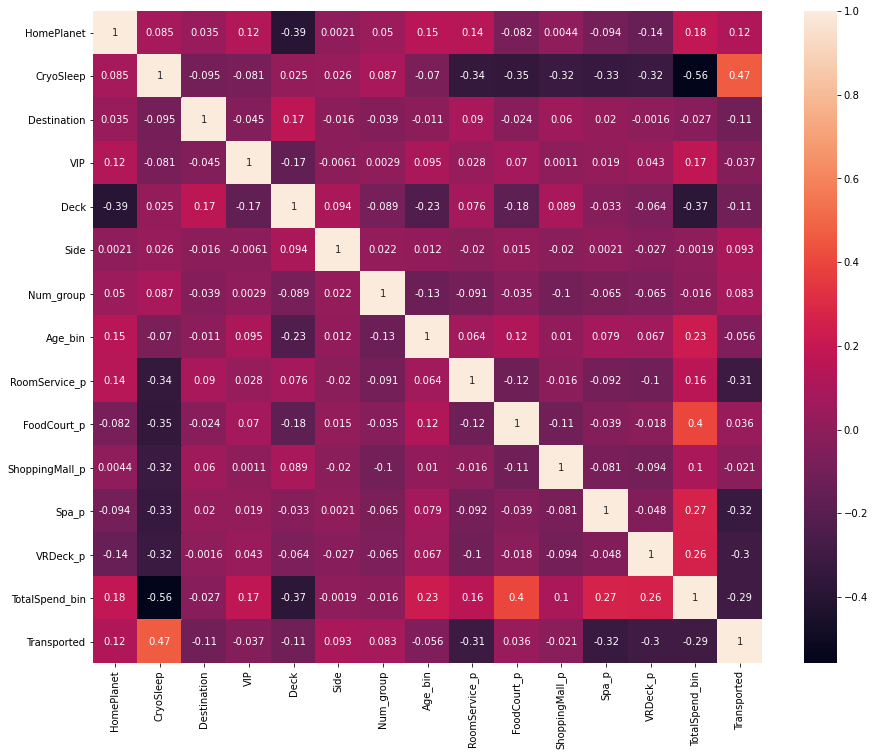

In [49]:
# Корелляция между признаками, есть мультиколлинеарность.
plt.figure(figsize=(15, 12))
sns.heatmap(data.corr(), annot=True)
plt.show()

С колонкой Transported (target) коррелирует колонка CryoSleep (0.47) и RoomService_p, Spa_p, VRDeck_p, TotalSpend_bin (каждый примерно по -0.3). Между этими признаками есть корреляция.

In [50]:
# Запишем признаки в переменную X, целевой признак в переменную y.
X = data.drop('Transported', axis=1)
y = data['Transported']

## Обучение моделей и оценка качества

In [51]:
# Функция применения модели, подбор некоторых параметров и отображения оценки качества модели.
# Для целевой колонки замечен баланс классов, поэтому будем использовать метрику Accuracy.
def model_display_metrics(model, X_train, y_train, X_test, y_test, param=None, model_params=None):
    if model_params is None:
        model_params = dict()
    print(model.__name__)
    model_ml = GridSearchCV(model(**model_params), param_grid=param, n_jobs=-1, verbose=1, scoring='accuracy')
    model_ml.fit(X_train, y_train)
    best_estimator = model_ml.best_estimator_
    print(f'Best estimator for {model.__name__}:', best_estimator)
    best_score = model_ml.best_score_
    print(f'Best score for {model.__name__}:', best_score)
    best_params = model_ml.best_params_
    print(f'Params for {model.__name__}:', best_params)

    coefs = pd.DataFrame({'Column': X.columns, 'Importance of feature': best_estimator.feature_importances_})
    sort_coefs = coefs.sort_values(by='Importance of feature')
    sns.barplot(data=sort_coefs, y='Column', x='Importance of feature', orient='h')
    plt.title(f'Feature Importance in the {model.__name__}')
    plt.show()
    
    y_pred = model_ml.predict(X_test)
    
    fig = plt.figure(figsize=(14, 10))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    
    ConfusionMatrixDisplay.from_estimator(best_estimator, X_test, y_test, ax=ax1, cmap='GnBu')
    ax1.grid(False)
    ax1.set_title(f'Confusion Matrix for {model.__name__}')
    
    RocCurveDisplay.from_estimator(best_estimator, X_test, y_test, ax=ax2)
    ax2.set_title(f'Roc Curve for {model.__name__}')
    ax2.plot([0, 1], [0, 1], color="gray", linestyle="--")
    
    PrecisionRecallDisplay.from_estimator(best_estimator, X_test, y_test, ax=ax3)
    ax3.set_title(f'Precision Recal for {model.__name__}')
        
    plt.tight_layout()   
    plt.show()
    
    print(f'Classification Report:')
    print(classification_report(y_test, y_pred))
    
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    roc_auc = round(roc_auc_score(y_test, model_ml.predict_proba(X_test)[:, 1]), 3)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)
    print('ROC-AUC score:', roc_auc)
    
    return [accuracy, precision, recall, f1, roc_auc, best_estimator, best_params, best_score]

In [52]:
# Параметры для DecisionTreeClassifier
DecisionTreeClassifier().get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

Какие параметры будем подбирать:
1) max_depth. Для классификации k классов необходимо брать дерево с глубиной не менее $\log_2 k$, так как мы хотим, чтобы в полученном дереве было не менее k листьев. Иначе дерево будет предсказывать < k классов, чего мы хотим избежать. Увеличение значения параметра max_depth приводит к увеличению точности классификации на обучающей выборке, но с некоторого момента увеличение значения max_depth приводит к ухудшению точности на тестовой выборке, так как начинается стадия переобучения. В данном датасете подбираем глубину от 2 и более.  
2) min_samples_leaf. Ограничение на минимальное количество элементов, которое может находиться в листовой вершине дерева. Данное условие необходимо для того, чтобы предсказание для данного листа было достаточно устойчиво. Например, если попал только один объект, то предсказание для данного листа будет равно таргету данного объекта, что является достаточно шумным предсказанием, а если попало 5 объектов, то предсказание будет более устойчиво к шуму и выбросам. Увеличение значения параметра min_samples_leaf - один из способов борьбы с переобучением при использовании решающих деревьев.  
3) min_samples_split. Минимальное количество элементов, которое должно попасть в вершину, чтобы её можно было разделить. При изменении значения min_samples_split происходит ситуация, аналогичной случаю, когда мы варьируем min_samples_leaf.    

DecisionTreeClassifier
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Best estimator for DecisionTreeClassifier: DecisionTreeClassifier(max_depth=9, min_samples_leaf=15, random_state=42)
Best score for DecisionTreeClassifier: 0.7924528812697457
Params for DecisionTreeClassifier: {'max_depth': 9, 'min_samples_leaf': 15, 'min_samples_split': 2}


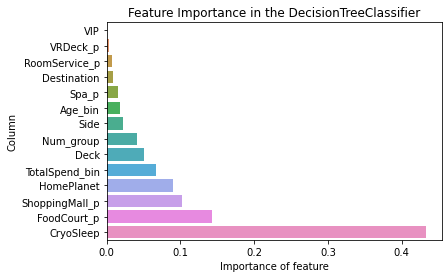

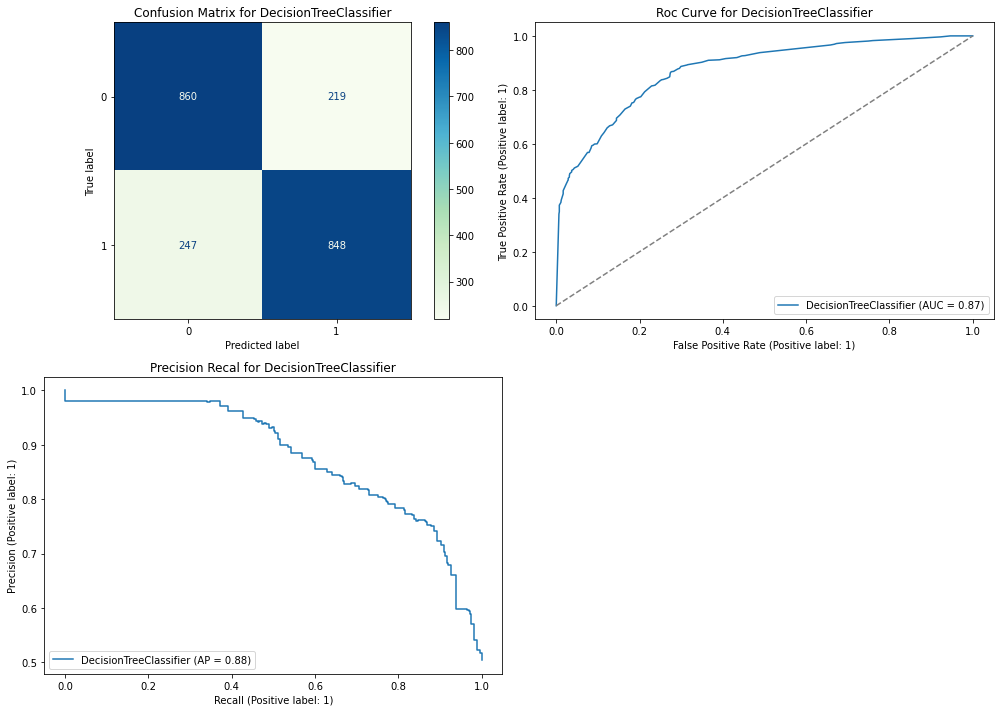

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1079
           1       0.79      0.77      0.78      1095

    accuracy                           0.79      2174
   macro avg       0.79      0.79      0.79      2174
weighted avg       0.79      0.79      0.79      2174

Accuracy: 0.786
Precision: 0.795
Recall: 0.774
F1-score: 0.784
ROC-AUC score: 0.874
DecisionTreeClassifier
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Best estimator for DecisionTreeClassifier: DecisionTreeClassifier(max_depth=8, min_samples_leaf=11, random_state=42)
Best score for DecisionTreeClassifier: 0.7912222384398439
Params for DecisionTreeClassifier: {'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 2}


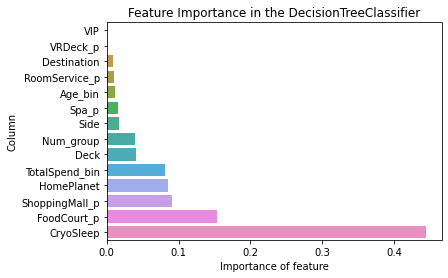

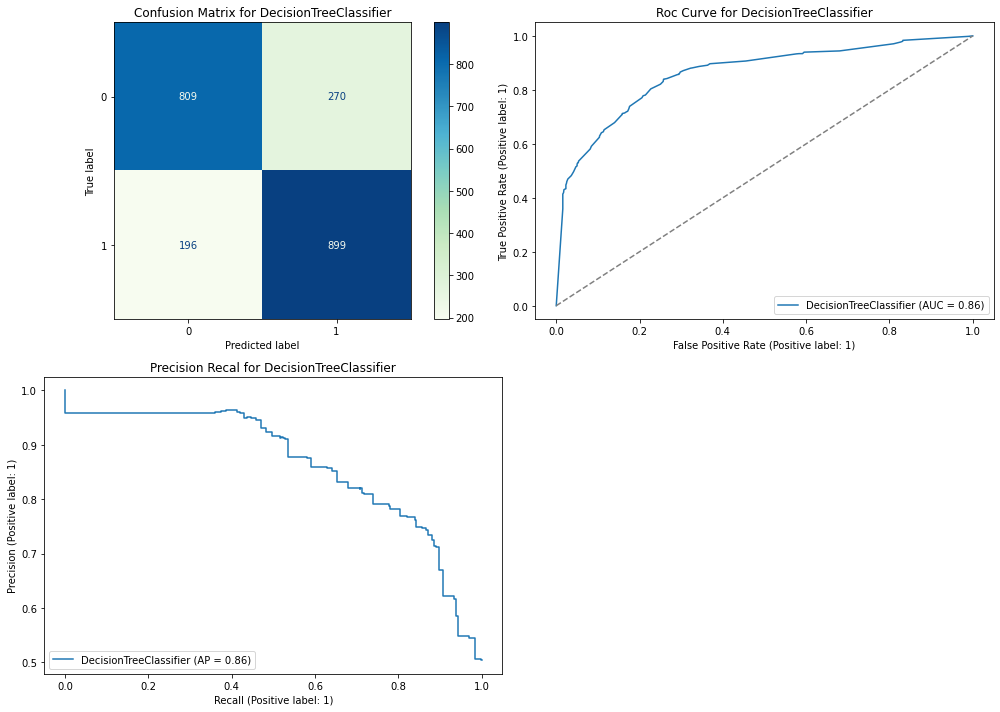

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.78      1079
           1       0.77      0.82      0.79      1095

    accuracy                           0.79      2174
   macro avg       0.79      0.79      0.79      2174
weighted avg       0.79      0.79      0.79      2174

Accuracy: 0.786
Precision: 0.769
Recall: 0.821
F1-score: 0.794
ROC-AUC score: 0.86
DecisionTreeClassifier
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Best estimator for DecisionTreeClassifier: DecisionTreeClassifier(max_depth=9, min_samples_leaf=20, random_state=42)
Best score for DecisionTreeClassifier: 0.7942930189416589
Params for DecisionTreeClassifier: {'max_depth': 9, 'min_samples_leaf': 20, 'min_samples_split': 2}


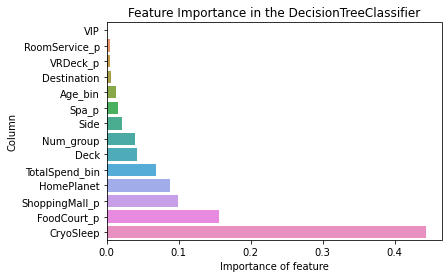

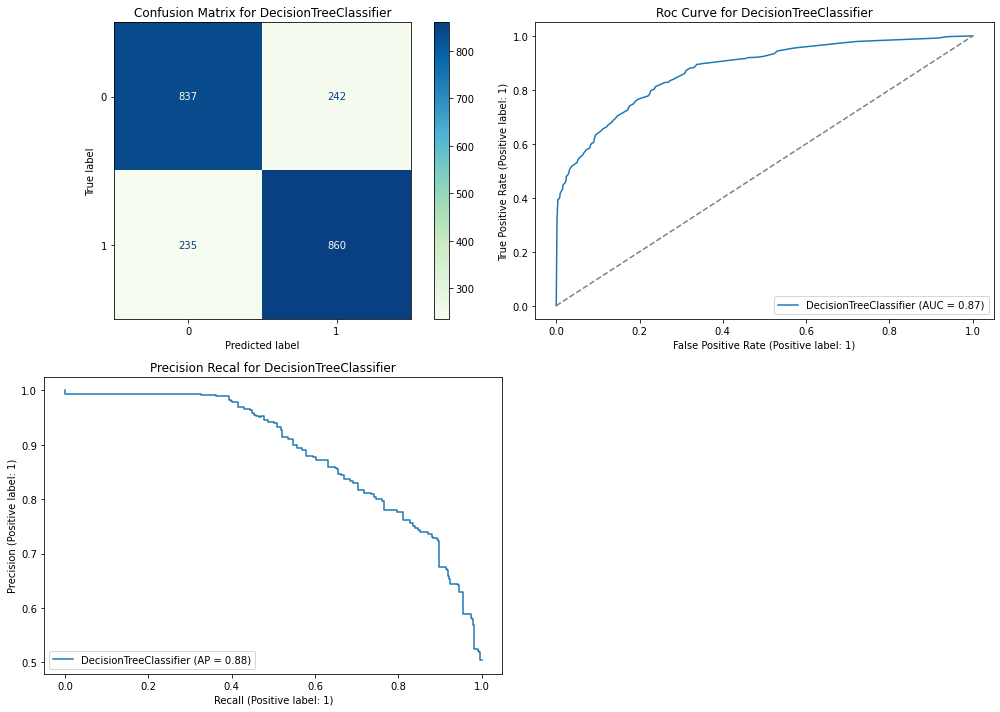

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1079
           1       0.78      0.79      0.78      1095

    accuracy                           0.78      2174
   macro avg       0.78      0.78      0.78      2174
weighted avg       0.78      0.78      0.78      2174

Accuracy: 0.781
Precision: 0.78
Recall: 0.785
F1-score: 0.783
ROC-AUC score: 0.872
DecisionTreeClassifier
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Best estimator for DecisionTreeClassifier: DecisionTreeClassifier(max_depth=9, min_samples_leaf=19, random_state=42)
Best score for DecisionTreeClassifier: 0.7880014972526826
Params for DecisionTreeClassifier: {'max_depth': 9, 'min_samples_leaf': 19, 'min_samples_split': 2}


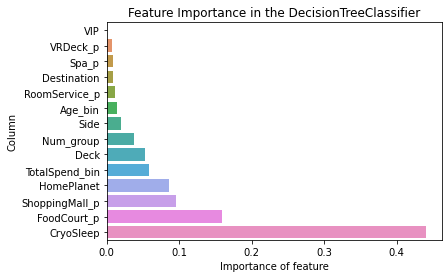

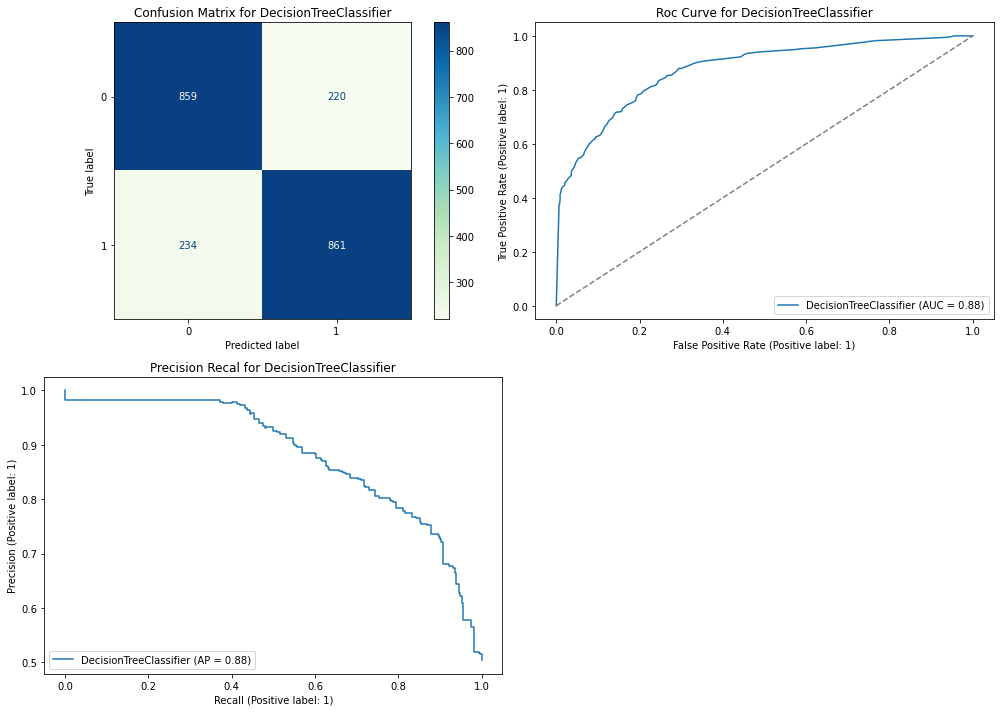

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1079
           1       0.80      0.79      0.79      1095

    accuracy                           0.79      2174
   macro avg       0.79      0.79      0.79      2174
weighted avg       0.79      0.79      0.79      2174

Accuracy: 0.791
Precision: 0.796
Recall: 0.786
F1-score: 0.791
ROC-AUC score: 0.876


In [53]:
# Разделим датафрейм на обучающую и тестовую выборки, задаем пропорцию классов при разделении на обучающий и проверяющий
# датасеты с помощью параметра stratify. Посмотрим на результаты с несколькими значениями random_state.
metrics = []
parameter_DT = {'max_depth': np.arange(2,10),
                'min_samples_leaf': np.arange(5,25),
                'min_samples_split': np.arange(2,6)
               }
for num in np.random.randint(0, 2**32, 4, dtype='uint32'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=num)
    metrics_balance = model_display_metrics(DecisionTreeClassifier, X_train, y_train, X_test, y_test, 
                                            param=parameter_DT, model_params=dict(random_state=42))
    metrics.append(metrics_balance + [num])

In [54]:
# Таблица DecisionTreeClassifier - метрики с указанием подобранных параметров (сортировка по колонке accuracy, по убыванию).
# С stratify.
pd.options.display.max_colwidth = 150
data_metrics_balance = pd.DataFrame(data=metrics, 
                                    columns=['accuracy', 'precision', 'recall', 'f1-score', 'roc_auc', 'best_estimator', 
                                             'best_params', 'best_score', 'random_state_train'])
data_metrics_balance.sort_values(by='accuracy', ascending=False)

,accuracy,precision,recall,f1-score,roc_auc,best_estimator,best_params,best_score,random_state_train
3,0.791,0.796,0.786,0.791,0.876,"DecisionTreeClassifier(max_depth=9, min_samples_leaf=19, random_state=42)","{'max_depth': 9, 'min_samples_leaf': 19, 'min_samples_split': 2}",0.788001,2717695762
0,0.786,0.795,0.774,0.784,0.874,"DecisionTreeClassifier(max_depth=9, min_samples_leaf=15, random_state=42)","{'max_depth': 9, 'min_samples_leaf': 15, 'min_samples_split': 2}",0.792453,153838845
1,0.786,0.769,0.821,0.794,0.860,"DecisionTreeClassifier(max_depth=8, min_samples_leaf=11, random_state=42)","{'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 2}",0.791222,121746554
2,0.781,0.780,0.785,0.783,0.872,"DecisionTreeClassifier(max_depth=9, min_samples_leaf=20, random_state=42)","{'max_depth': 9, 'min_samples_leaf': 20, 'min_samples_split': 2}",0.794293,1767171088


DecisionTreeClassifier
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Best estimator for DecisionTreeClassifier: DecisionTreeClassifier(max_depth=8, min_samples_leaf=9, random_state=42)
Best score for DecisionTreeClassifier: 0.786315793190796
Params for DecisionTreeClassifier: {'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 2}


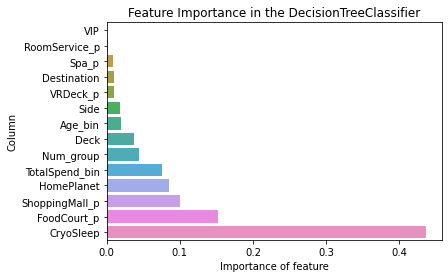

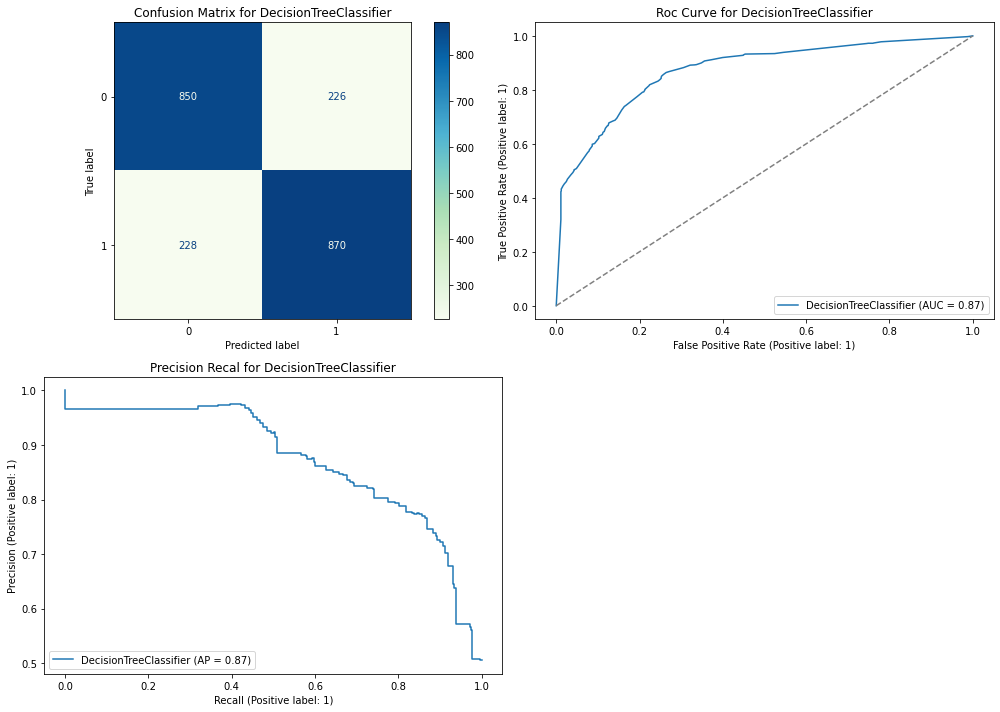

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1076
           1       0.79      0.79      0.79      1098

    accuracy                           0.79      2174
   macro avg       0.79      0.79      0.79      2174
weighted avg       0.79      0.79      0.79      2174

Accuracy: 0.791
Precision: 0.794
Recall: 0.792
F1-score: 0.793
ROC-AUC score: 0.871
DecisionTreeClassifier
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Best estimator for DecisionTreeClassifier: DecisionTreeClassifier(max_depth=9, min_samples_leaf=17, random_state=42)
Best score for DecisionTreeClassifier: 0.7893863382755227
Params for DecisionTreeClassifier: {'max_depth': 9, 'min_samples_leaf': 17, 'min_samples_split': 2}


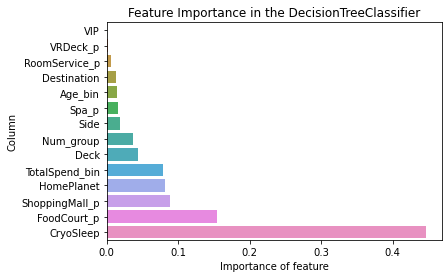

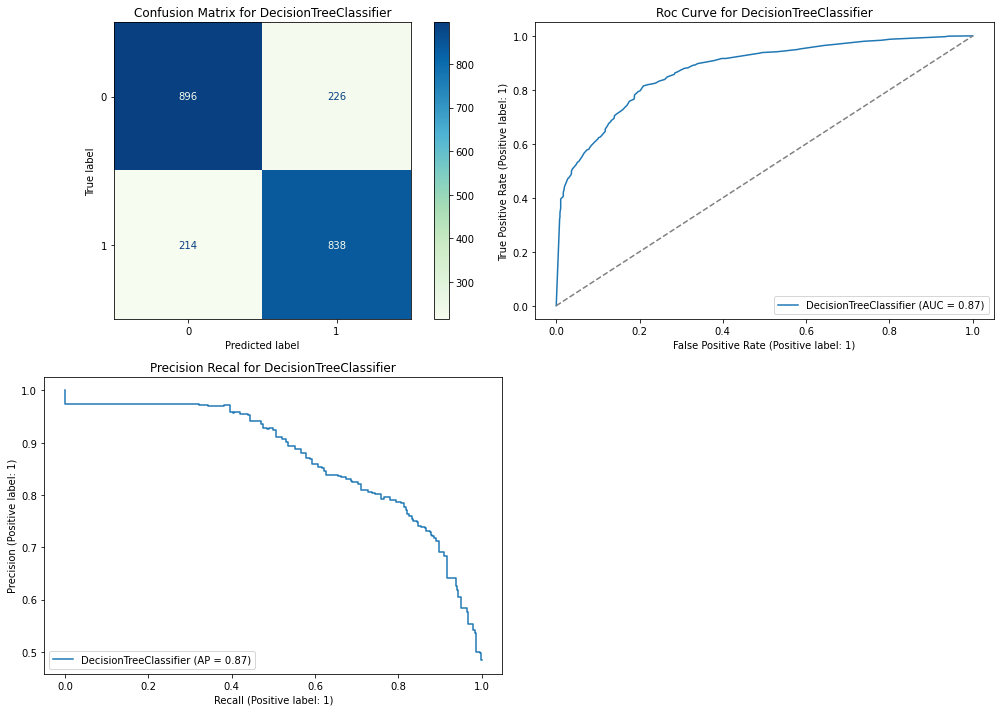

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1122
           1       0.79      0.80      0.79      1052

    accuracy                           0.80      2174
   macro avg       0.80      0.80      0.80      2174
weighted avg       0.80      0.80      0.80      2174

Accuracy: 0.798
Precision: 0.788
Recall: 0.797
F1-score: 0.792
ROC-AUC score: 0.875
DecisionTreeClassifier
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Best estimator for DecisionTreeClassifier: DecisionTreeClassifier(max_depth=8, min_samples_leaf=17, random_state=42)
Best score for DecisionTreeClassifier: 0.7858581423708383
Params for DecisionTreeClassifier: {'max_depth': 8, 'min_samples_leaf': 17, 'min_samples_split': 2}


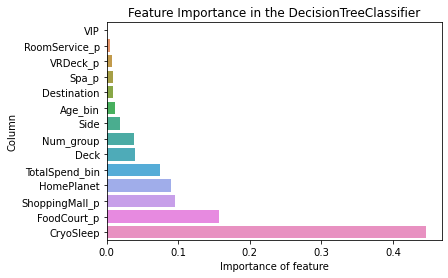

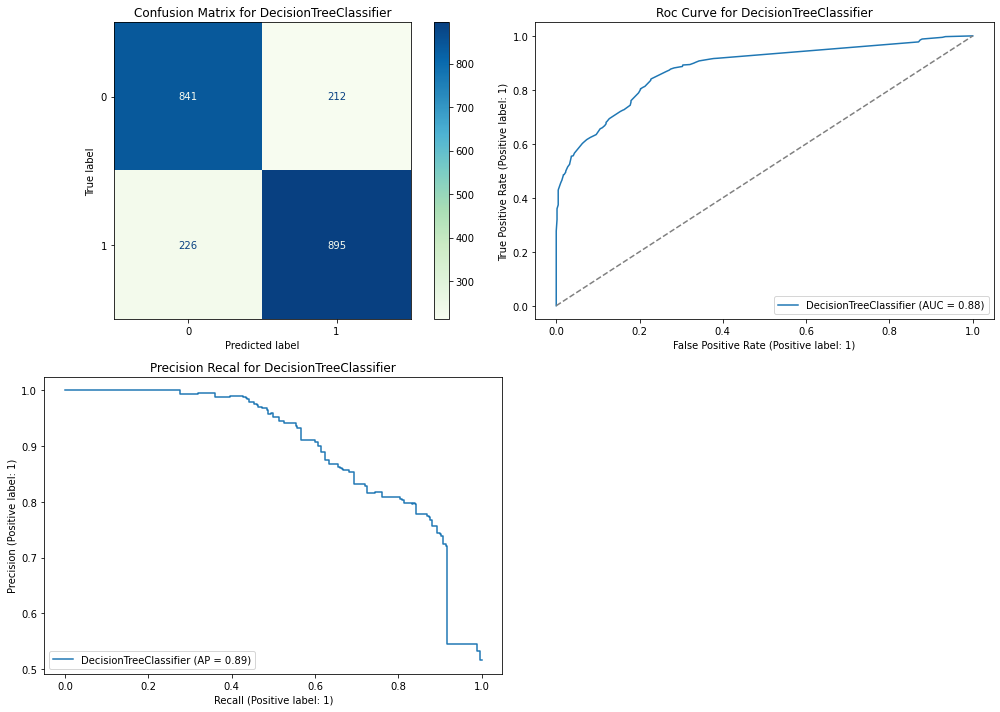

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1053
           1       0.81      0.80      0.80      1121

    accuracy                           0.80      2174
   macro avg       0.80      0.80      0.80      2174
weighted avg       0.80      0.80      0.80      2174

Accuracy: 0.799
Precision: 0.808
Recall: 0.798
F1-score: 0.803
ROC-AUC score: 0.878
DecisionTreeClassifier
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Best estimator for DecisionTreeClassifier: DecisionTreeClassifier(max_depth=8, min_samples_leaf=11, random_state=42)
Best score for DecisionTreeClassifier: 0.7886165243962729
Params for DecisionTreeClassifier: {'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 2}


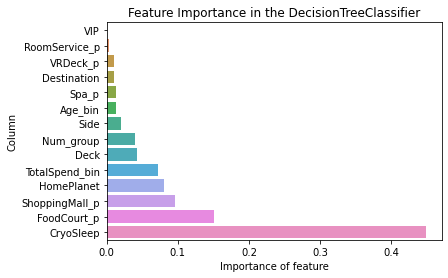

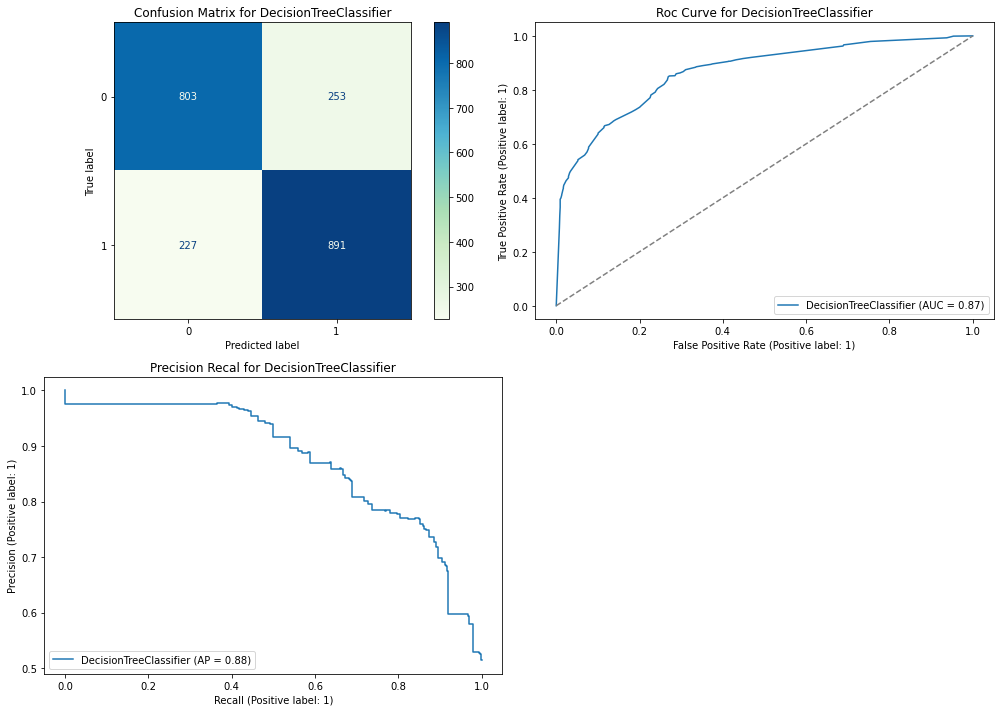

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1056
           1       0.78      0.80      0.79      1118

    accuracy                           0.78      2174
   macro avg       0.78      0.78      0.78      2174
weighted avg       0.78      0.78      0.78      2174

Accuracy: 0.779
Precision: 0.779
Recall: 0.797
F1-score: 0.788
ROC-AUC score: 0.866


In [55]:
# Разделим датафрейм на обучающую и тестовую выборки, без задания пропорции классов при разделении на обучающий и проверяющий
# датасеты с помощью параметра stratify. Посмотрим на результаты с несколькими значениями random_state.
metrics_ = []
for num in np.random.randint(0, 2**32, 4, dtype='uint32'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=num)
    metrics_w_o_balance = model_display_metrics(DecisionTreeClassifier, X_train, y_train, X_test, y_test, 
                                                param=parameter_DT, model_params=dict(random_state=42))
    metrics_.append(metrics_w_o_balance + [num])

In [56]:
# Таблица DecisionTreeClassifier - метрики с указанием подобранных параметров (сортировка по колонке accuracy, по убыванию).
# Без stratify.
data_metrics_balance = pd.DataFrame(data=metrics_, 
                                    columns=['accuracy', 'precision', 'recall', 'f1-score', 'roc_auc', 'best_estimator', 
                                             'best_params', 'best_score', 'random_state_train'])
data_metrics_balance.sort_values(by='accuracy', ascending=False)

,accuracy,precision,recall,f1-score,roc_auc,best_estimator,best_params,best_score,random_state_train
2,0.799,0.808,0.798,0.803,0.878,"DecisionTreeClassifier(max_depth=8, min_samples_leaf=17, random_state=42)","{'max_depth': 8, 'min_samples_leaf': 17, 'min_samples_split': 2}",0.785858,4207247379
1,0.798,0.788,0.797,0.792,0.875,"DecisionTreeClassifier(max_depth=9, min_samples_leaf=17, random_state=42)","{'max_depth': 9, 'min_samples_leaf': 17, 'min_samples_split': 2}",0.789386,1042450716
0,0.791,0.794,0.792,0.793,0.871,"DecisionTreeClassifier(max_depth=8, min_samples_leaf=9, random_state=42)","{'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 2}",0.786316,4134372104
3,0.779,0.779,0.797,0.788,0.866,"DecisionTreeClassifier(max_depth=8, min_samples_leaf=11, random_state=42)","{'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 2}",0.788617,1783002640
